In [3]:
t_end = 'Now'
duration_in_day = 30
figformat = 'retina'
time_interval = '1h'
exclude='cryo3'

In [4]:
%matplotlib inline
%config InlineBackend.figure_formats = [figformat]

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


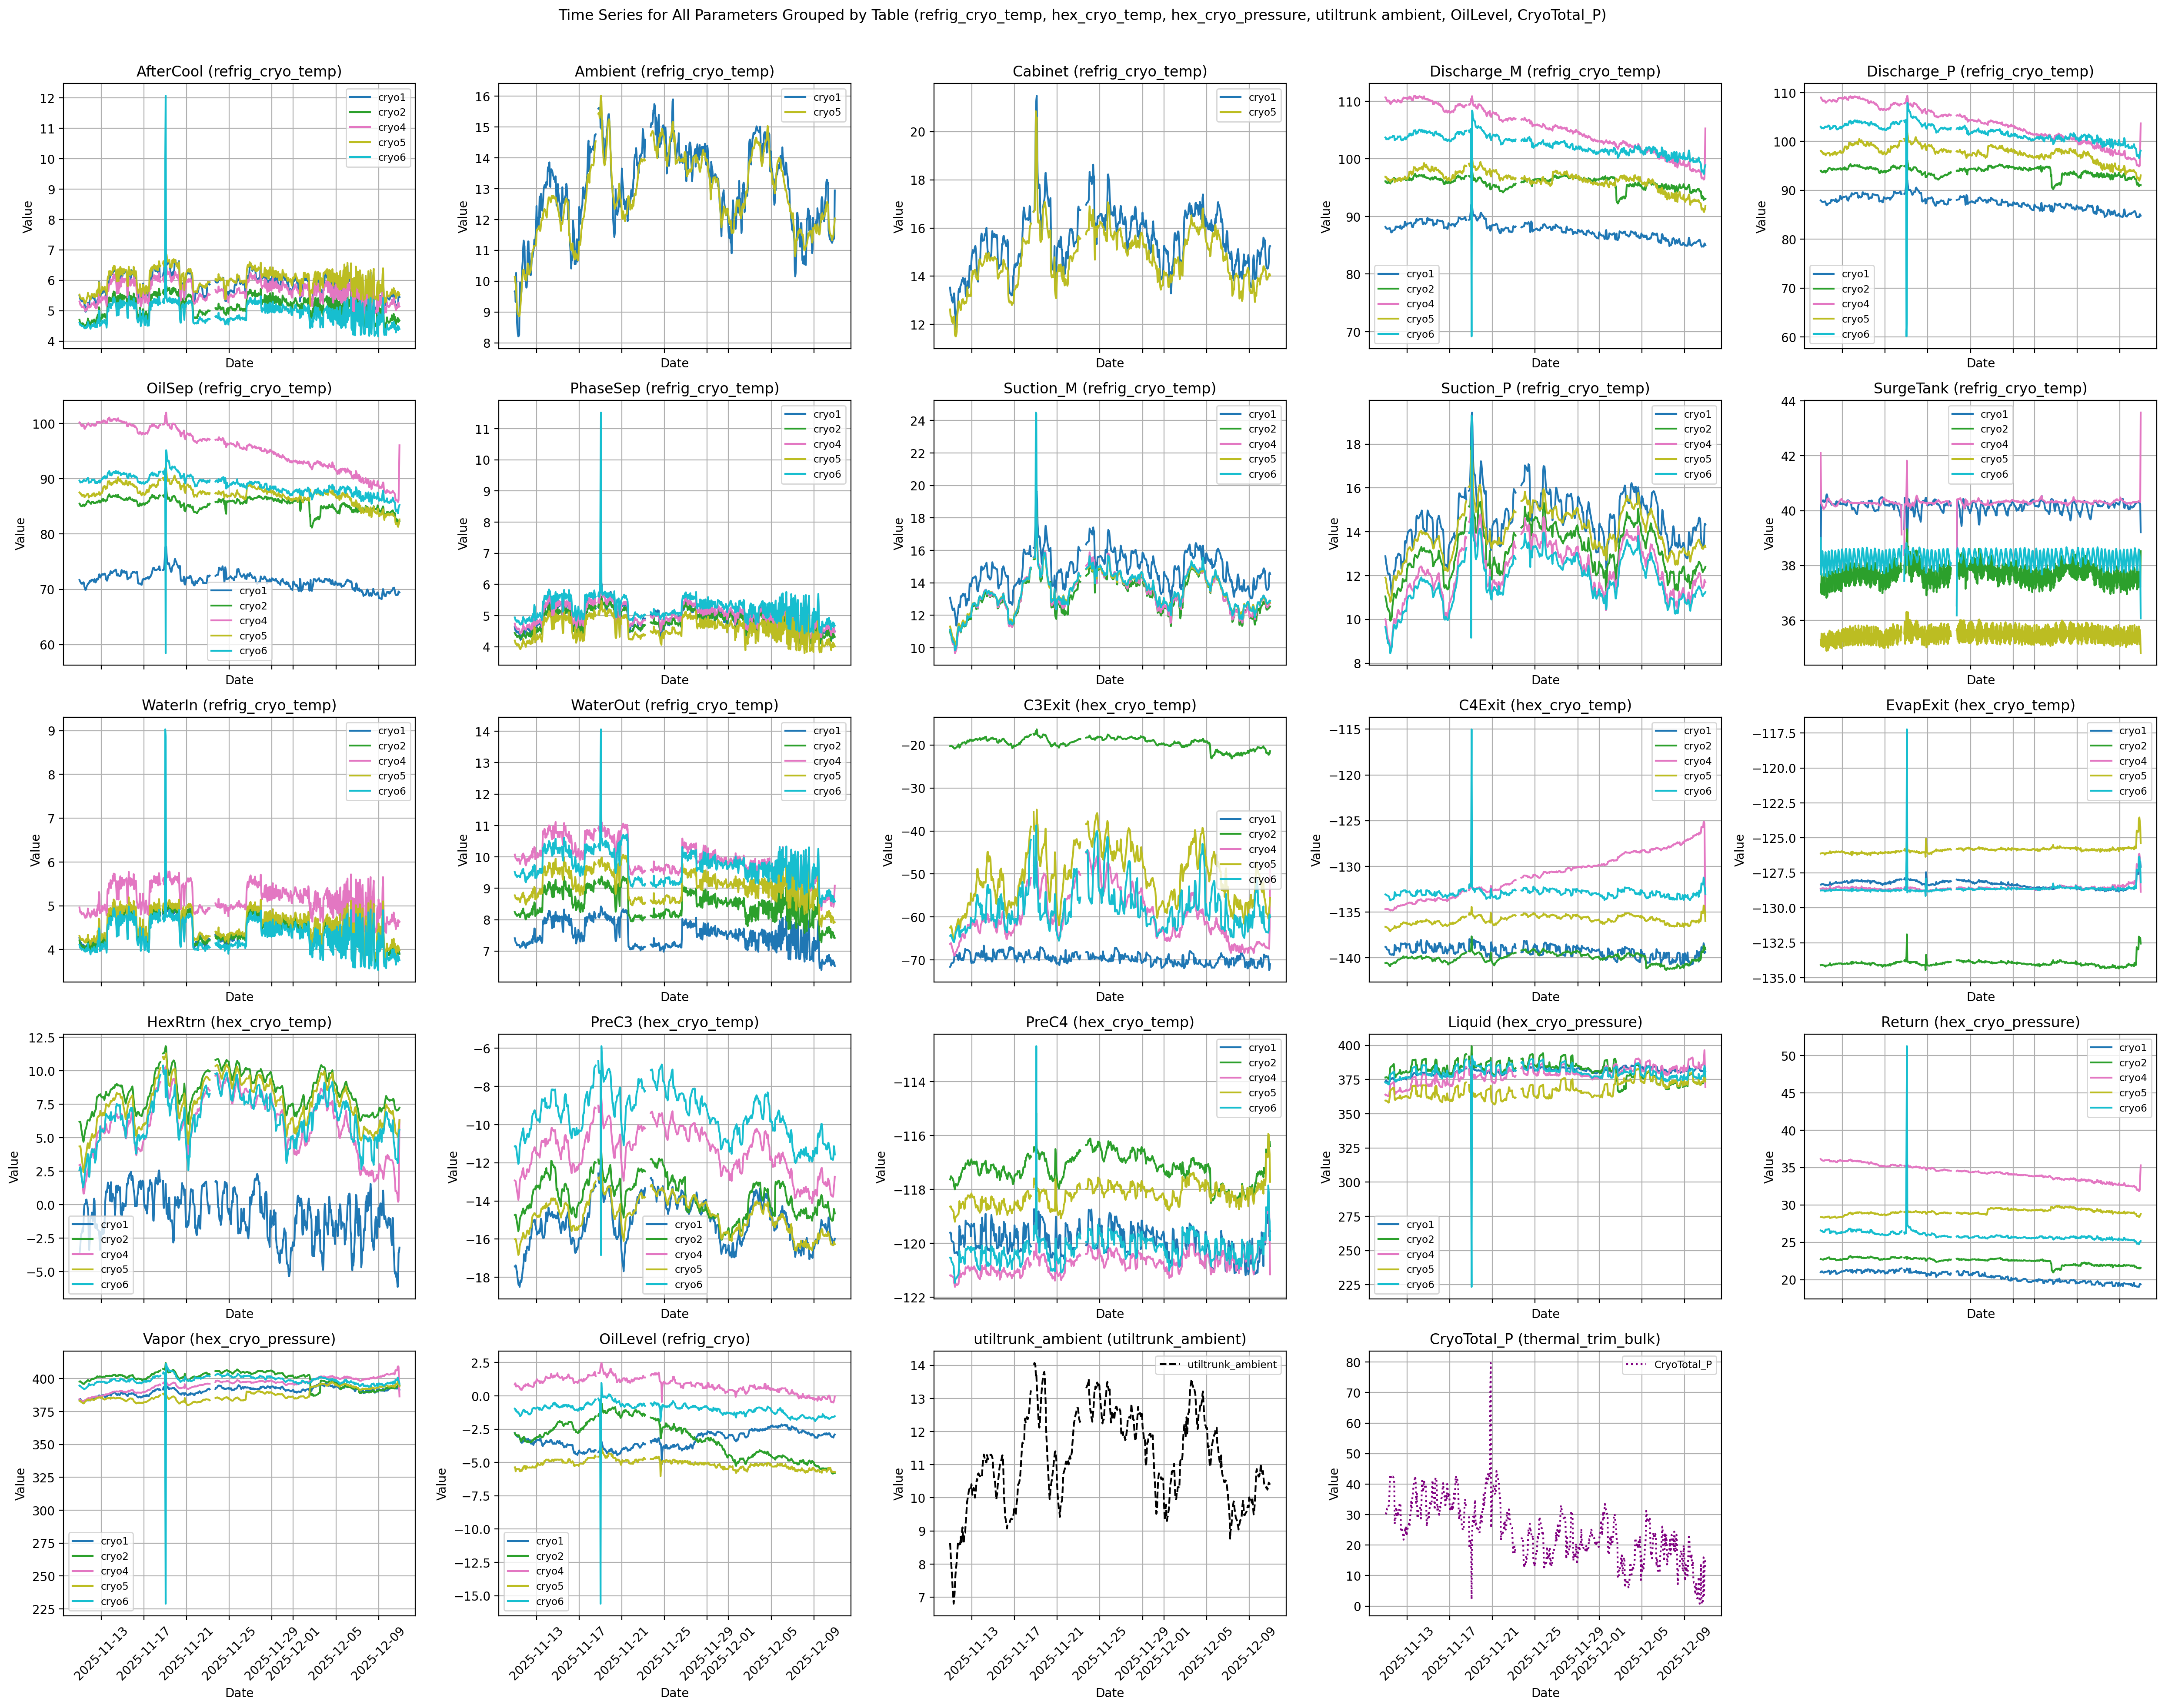

In [5]:
# Plot all sources grouped by table: refrig_cryo_temp, hex_cryo_temp, hex_cryo_pressure, utiltrunk ambient, refrig_cryo (OilLevel), thermal_trim_bulk (CryoTotal_P)
from lsst_efd_client import EfdClient
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from astropy.time import Time, TimeDelta
import numpy as np
import pandas as pd

client = EfdClient("usdf_efd")

# Prepare time range
if t_end == 'Now':
    t_end_val = Time.now()
else:
    t_end_val = Time(t_end)
t_start_val = t_end_val - TimeDelta(duration_in_day, format='jd')
t_start = t_start_val.iso
t_end = t_end_val.iso

def tidy_result(result, label_cols=("Source","Cryo"), override_name=None):
    """
    Convert EFD query results (dict or list of DataFrames) into a list of DataFrames with
    a single value column, optionally labeled by a tag column (e.g., Source or Cryo).
    - label_cols: tuple/list of candidate column names to use as the label (first found wins).
    - override_name: if provided and no label column is present, use this as the column name.
    """
    dfs = []
    if isinstance(result, dict):
        items = result.values()
    elif isinstance(result, list):
        items = result
    else:
        items = []
    for df in items:
        if df is None or df.empty:
            continue
        # Determine label name from available columns
        label_name = None
        label_col_present = None
        for col in label_cols:
            if col in df.columns and len(df[col]) > 0:
                label_col_present = col
                label_name = df[col].iloc[0]
                break
        # Normalize value column name
        if 'mean' in df.columns and 'value' not in df.columns:
            df = df.rename(columns={'mean': 'value'})
        # Drop label column if present
        if label_col_present in df.columns:
            df = df.drop(columns=[label_col_present])
        # Final column naming
        final_name = label_name if label_name else (override_name if override_name else 'value')
        if 'value' in df.columns:
            df = df.rename(columns={'value': final_name})
        elif final_name != 'value' and final_name not in df.columns:
            # If query used AS already, keep it; otherwise ensure a single named column
            pass
        dfs.append(df)
    return dfs

# Collect sources by table for all cryo units
sources_by_table = {
    'refrig_cryo_temp': set(),
    'hex_cryo_temp': set(),
    'hex_cryo_pressure': set(),
    'refrig_cryo': set(),            # for OilLevel per cryo
}
cryo_data = {}
cryo_list = [f'cryo{i+1}' for i in range(6)]
if exclude is not None:
    if isinstance(exclude, str):
        exclude_set = {exclude}
    else:
        exclude_set = set(exclude)
    cryo_list = [c for c in cryo_list if c not in exclude_set]
for cryo in cryo_list:
    # refrig_cryo_temp
    refrig_query = f'''
    SELECT mean("temperature")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
      AND "Agent"='refrig2'
    GROUP BY time({time_interval}), "Source" FILL(null)
    '''
    refrig_result = await client.influx_client.query(refrig_query)
    refrig_dfs = tidy_result(refrig_result, label_cols=("Source","Cryo"))
    df_refrig = pd.concat(refrig_dfs, axis=1) if refrig_dfs else pd.DataFrame()
    sources_by_table['refrig_cryo_temp'].update(df_refrig.columns.tolist())

    # hex_cryo_temp
    hex_query = f'''
    SELECT mean("temperature")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_temp"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
    GROUP BY time({time_interval}), "Source" FILL(null)
    '''
    hex_result = await client.influx_client.query(hex_query)
    hex_dfs = tidy_result(hex_result, label_cols=("Source","Cryo"))
    df_hex = pd.concat(hex_dfs, axis=1) if hex_dfs else pd.DataFrame()
    sources_by_table['hex_cryo_temp'].update(df_hex.columns.tolist())

    # hex_cryo_pressure
    pressure_query = f'''
    SELECT mean("pressure")
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_pressure"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Cryo"='{cryo}' 
    GROUP BY time({time_interval}), "Source" FILL(null)
    '''
    pressure_result = await client.influx_client.query(pressure_query)
    pressure_dfs = tidy_result(pressure_result, label_cols=("Source","Cryo"))
    df_pressure = pd.concat(pressure_dfs, axis=1) if pressure_dfs else pd.DataFrame()
    sources_by_table['hex_cryo_pressure'].update(df_pressure.columns.tolist())

    # refrig_cryo: OilLevel (per cryo, always label as OilLevel)
    oil_query = f'''
    SELECT mean("OilLevel") AS "OilLevel"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo"
    WHERE time > '{t_start}' AND time < '{t_end}'
      AND "Agent"='refrig2'
      AND "Cryo"='{cryo}'
    GROUP BY time({time_interval}) FILL(null)
    '''
    oil_result = await client.influx_client.query(oil_query)
    # Always create a column named OilLevel for each cryo
    if isinstance(oil_result, pd.DataFrame) and not oil_result.empty and 'OilLevel' in oil_result.columns:
        df_oil = oil_result.rename(columns={'OilLevel': f'OilLevel_{cryo}'})
        sources_by_table['refrig_cryo'].add(f'OilLevel_{cryo}')
    else:
        df_oil = pd.DataFrame()
    # merge all into per-cryo dataframe
    df_all = pd.concat([df_refrig, df_hex, df_pressure, df_oil], axis=1)
    cryo_data[cryo] = df_all

# utiltrunk ambient (outside air temperature)
utiltrunk_query = f'''
SELECT mean("AmbAirtemp") AS "utiltrunk_ambient"
FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.utiltrunk_body"
WHERE time > '{t_start}' AND time < '{t_end}'
  AND "Agent"='utiltrunk'
GROUP BY time({time_interval}) FILL(null)
'''
utiltrunk_result = await client.influx_client.query(utiltrunk_query)
if isinstance(utiltrunk_result, pd.DataFrame):
    utiltrunk_ambient = utiltrunk_result['utiltrunk_ambient'] if 'utiltrunk_ambient' in utiltrunk_result.columns else None
    utiltrunk_dates = pd.to_datetime(utiltrunk_result.index) if utiltrunk_ambient is not None else None
else:
    utiltrunk_ambient = None
    utiltrunk_dates = None

# thermal_trim_bulk: CryoTotal_P (global, not per cryo)
thermal_query = f'''
SELECT mean("CryoTotal_P") AS "CryoTotal_P"
FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.thermal_trim_bulk"
WHERE time > '{t_start}' AND time < '{t_end}'
GROUP BY time({time_interval}) FILL(null)
'''
thermal_result = await client.influx_client.query(thermal_query)
if isinstance(thermal_result, pd.DataFrame) and 'CryoTotal_P' in thermal_result.columns:
    cryo_total_p = thermal_result['CryoTotal_P']
    cryo_total_p_dates = pd.to_datetime(thermal_result.index)
else:
    cryo_total_p = None
    cryo_total_p_dates = None

# Prepare grouped sources list
grouped_sources = []
for tbl in ['refrig_cryo_temp', 'hex_cryo_temp', 'hex_cryo_pressure']:
    tbl_sources = sorted(list(sources_by_table[tbl]))
    grouped_sources.extend([(tbl, s) for s in tbl_sources])
# OilLevel: one panel, all cryos
if sources_by_table['refrig_cryo']:
    grouped_sources.append(('refrig_cryo', 'OilLevel'))
if utiltrunk_ambient is not None:
    grouped_sources.append(('utiltrunk_ambient', 'utiltrunk_ambient'))
if cryo_total_p is not None:
    grouped_sources.append(('thermal_trim_bulk', 'CryoTotal_P'))

n_sources = len(grouped_sources)
ncols = 5
nrows = int(np.ceil(n_sources / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True)
axes = axes.flatten()
cryo_colors = plt.cm.tab10(np.linspace(0,1,6))

for idx, (tbl, source) in enumerate(grouped_sources):
    ax = axes[idx]
    plotted = False
    if tbl == 'refrig_cryo' and source == 'OilLevel':
        # Plot all OilLevel_{cryo} on one panel
        for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
            if exclude is not None and cryo in exclude_set:
                continue
            col = f'OilLevel_{cryo}'
            if cryo in cryo_data and col in cryo_data[cryo].columns:
                dates = pd.to_datetime(cryo_data[cryo].index)
                ax.plot(dates, cryo_data[cryo][col], label=cryo, color=cryo_colors[i])
                plotted = True
    elif tbl in ['refrig_cryo_temp', 'hex_cryo_temp', 'hex_cryo_pressure']:
        for i, cryo in enumerate([f'cryo{j+1}' for j in range(6)]):
            if exclude is not None and cryo in exclude_set:
                continue
            if cryo in cryo_data and source in cryo_data[cryo].columns:
                dates = pd.to_datetime(cryo_data[cryo].index)
                ax.plot(dates, cryo_data[cryo][source], label=cryo, color=cryo_colors[i])
                plotted = True
    if tbl == 'utiltrunk_ambient' and utiltrunk_ambient is not None:
        ax.plot(utiltrunk_dates, utiltrunk_ambient, label='utiltrunk_ambient', color='black', linestyle='--')
        plotted = True
    if tbl == 'thermal_trim_bulk' and cryo_total_p is not None:
        ax.plot(cryo_total_p_dates, cryo_total_p, label='CryoTotal_P', color='purple', linestyle=':')
        plotted = True
    if plotted:
        ax.set_title(f'{source} ({tbl})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend(loc='best', fontsize='small')
    else:
        ax.set_title(f'{source} ({tbl}) (no data)')
        ax.axis('off')
for idx in range(n_sources, len(axes)):
    axes[idx].axis('off')
plt.suptitle('Time Series for All Parameters Grouped by Table (refrig_cryo_temp, hex_cryo_temp, hex_cryo_pressure, utiltrunk ambient, OilLevel, CryoTotal_P)')
plt.tight_layout(rect=[(0, 0, 1, 0.97)][0])
plt.show()
